In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdicom
import os
import pandas as pd
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm

from PIL import Image
from collections import Counter, defaultdict
from natsort import natsorted

import keras
from keras.preprocessing.image import array_to_img

# from utils import clean_slice, sort_paths, rotate_side_lr, rotate_horisontally

Using TensorFlow backend.


In [2]:
#list all dicom images
dicom_path = "Dataset"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            #print(lstFilesDCM)
natsorted(lstFilesDCM)
print("Number of all files: ", len(lstFilesDCM))

ct_paths = []
for e in lstFilesDCM:
    if e.split('/')[-1][:2]=="CT":
        ct_paths.append(e)
        
print("Number of CT files: ", len(ct_paths))
    

Number of all files:  8122
Number of CT files:  2860


In [3]:
RefDs = pdicom.read_file(ct_paths[0])
print(RefDs)

# RefDsList = []
# for elem in ct_paths:
#     RefDsList.append(pdicom.read_file(elem))
    
# RefDsList

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181018'
(0008, 0013) Instance Creation Time              TM: '070123'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017071308013339600001230
(0008, 0020) Study Date                          DA: '20170713'
(0008, 0021) Series Date                         DA: '20170713'
(0008, 0022) Acquisition Date                    DA: '20170713'
(0008, 0023) Content Date                        DA: '20170713'
(0008, 0030) Study Time                          TM: '110508.577'
(0008, 0031) Series Time                         TM: '111434.29'
(0008, 0032) Acquisition Time                    TM: '111425.167'
(0008, 0033) Content Time                        TM: '111425.167'
(0008, 00

In [4]:
arr_shapes = []
d = dict()
# loop through all the DICOM files
for filenameDCM in tqdm(ct_paths):
    if "Image" not in filenameDCM:
        continue
    # read the file
    ds = pdicom.read_file(filenameDCM)
    arr_shapes.append(ds.pixel_array.shape)
    shape = ds.pixel_array.shape
    if shape in d.keys():
        d[shape].append(filenameDCM)
    else:
        d[shape] = [filenameDCM]
print(len(arr_shapes))
Counter(arr_shapes)

100%|██████████| 2860/2860 [00:13<00:00, 211.65it/s]

2860


Counter({(512, 512): 2860})

In [5]:
from typing import List
def sort_paths(paths: List[str]) -> List[str]:  
    """Augmented natural sorting to group together brain slices"""
    ct_paths_sorted = natsorted(paths)
    curr_patient_id = ct_paths_sorted[0].split('/')[-2]
    fst = []
    snd = defaultdict(list)
    ct_sorted = []
    for i in range(len(ct_paths_sorted)-1):
        patient_id = ct_paths_sorted[i].split('/')[-2]
        if patient_id!=curr_patient_id:
            ct_sorted += fst 
            for scan_id in sorted(snd.keys()):
                ct_sorted += snd[scan_id]
            fst = []
            snd = defaultdict(list)
            curr_patient_id = patient_id
            
        if '_' in ct_paths_sorted[i].split('/')[-1]:
            scan_id = ct_paths_sorted[i].split('/')[-1].split('_')[-1]
            snd[scan_id].append(ct_paths_sorted[i])
        else:
            fst.append(ct_paths_sorted[i])

    ct_sorted += fst
    for scan_id in sorted(snd.keys()):
        ct_sorted += snd[scan_id]

    return ct_sorted

ct_paths_sorted = sort_paths(d[(512,512)])

In [6]:
slice2brain_id = []
for e in ct_paths_sorted:
    slice2brain_id.append(e.split('/')[-2])
Counter(slice2brain_id)

Counter({'339663': 77,
         '345923': 72,
         '346231': 69,
         '351423': 170,
         '353891': 65,
         '354152': 75,
         '361113': 68,
         '362946': 65,
         '363578': 73,
         '363740': 69,
         '378104': 118,
         '379682': 386,
         '380225': 77,
         '380677': 61,
         '383593': 270,
         '385185': 71,
         '385948': 70,
         '386346': 76,
         '386348': 133,
         '386661': 71,
         '386662': 70,
         '386800': 82,
         '386801': 77,
         '387098': 66,
         '387295': 67,
         '387404': 66,
         '387607': 72,
         '387719': 74,
         '387722': 73,
         '388070': 76})

In [7]:
arr = np.zeros((512, 512, len(ct_paths_sorted)))

for i in tqdm(range(len(ct_paths_sorted))):
    ds = pdicom.read_file(ct_paths_sorted[i]) 
    arr[:, :, i] = ds.pixel_array 

len(arr)

100%|██████████| 2859/2859 [00:49<00:00, 57.38it/s] 


512

In [ ]:
print(arr.dtype)
print(arr.shape)
print(np.max(arr))
print(np.min(arr))
print("mean: ", np.mean(arr))
print("n pixels less than 5: ", np.sum(arr<5))
print("n pixels more than 5: ", np.sum(arr>=5))
print("mean of pixels greater than 5: ", np.mean(arr[arr>5]))
# print("std of pixels greater than 5: ", np.std(arr[arr>5]))

float64
(512, 512, 2859)
8000.0
0.0
mean:  251.95584692059384
n pixels less than 5:  476731411
n pixels more than 5:  272738285


In [ ]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    plt.imshow(arr[:,:,i])
plt.show()

In [ ]:
# im = array_to_img(ArrayDicom[:,:,1].reshape(512, 512, -1)) 
# IMG_SIZE = 224      

# new_size = tuple([int(x*(float(IMG_SIZE)/max(im.size))) for x in im.size])
# im_resized       = im.resize(new_size, Image.ANTIALIAS)
# new_im   = Image.new("L", (IMG_SIZE, IMG_SIZE))
# new_im.paste(im_resized, 
#              ((IMG_SIZE-new_size[0])//2,
#               (IMG_SIZE-new_size[1])//2))

# resized_image = np.array(new_im).reshape(224, 224, 1)
# array_to_img(resized_image) 

In [ ]:
kernel = np.ones((5,5),np.uint8)
img = arr[:,:,7]
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
erode = cv2.erode(img, kernel, iterations = 1)
# dilation2 = cv2.dilate(closing,kernel,iterations = 1)
thres = erode>0
thres = np.array(thres, dtype=np.uint8)
plt.imshow(closing)
plt.show()
plt.imshow(erode)
plt.show()
plt.imshow(thres)

In [ ]:
mask = np.zeros(img.shape,np.uint8)
imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))

index = areas.index(max(areas))
cnt = contours[index]
mask = cv2.drawContours(mask,[cnt],0,255,-1)
plt.imshow(mask)

In [ ]:
def clean_slice(img, erode_iter = 6, dilate_iter = 1):
    """
    too much noise remains -> increase erode_iter
    too little brain left -> increase dilate_iter
    returns 2D array
    
    """
    img = img.copy()
    kernel = np.ones((5,5),np.uint8)
    if len(img.shape)==3:
        img = img[:,:,0]
    img_morph = cv2.erode(img, kernel, iterations = erode_iter)
    thres = img_morph>0
    thres = np.array(thres, dtype=np.uint8)
    
    mask = np.zeros(thres.shape, np.uint8)
    imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = []
    for cnt in contours:
        areas.append(cv2.contourArea(cnt))
        
    index = areas.index(max(areas))
    cnt = contours[index]
    mask = cv2.drawContours(mask,[cnt],0,255,-1)
    mask = cv2.dilate(mask, kernel,iterations = dilate_iter)
    mask = mask>1
    img[~mask] = 0
    
    return img

a= clean_slice(img)
plt.imshow(a)

In [ ]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    img = clean_slice(arr[:,:,i])
    plt.imshow(img)
plt.show()

In [ ]:
def get_slice_index(ct_paths_sorted, verbose=False):
    j = 0
    brain_count = 0
    slice_index = []
    for i in range(len(ct_paths_sorted)-1):
        a = ct_paths_sorted[i].split("Image")[-1].split('.')[0].strip()
        b = ct_paths_sorted[i+1].split("Image")[-1].split('.')[0].strip()
        new_brain = '_' in b and '_' not in a
        if '_' in a:
            a = a.split('_')[-2]
        if '_' in b:
            b = b.split('_')[-2]
        a = int(a)
        b = int(b)
        if a>b or new_brain:
            if verbose:
                print("#"*12)
                print(ct_paths_sorted[i])
                print(ct_paths_sorted[i+1])
                print("number of slices: ", i-j)
            slice_index.append((j, i))
            j = i
            brain_count += 1
    if verbose:
        print("number of brain scans: ", brain_count)
    return slice_index

get_slice_index(ct_paths_sorted, verbose=True)

In [ ]:
def get_brain(scan_id, ct_paths_sorted, arr_all, slice_index=None):
    if slice_index is None:
        slice_index = get_slice_index(ct_paths_sorted)
        
    scan = arr_all[:, :, slice_index[scan_id][0]:slice_index[scan_id][1]]
    return scan

scan = get_brain(1, ct_paths_sorted, arr,)

In [48]:
def plot_slices(arr, n_slices_to_plot=4, offset=0, clean=False):
    n_rows = n_slices_to_plot // 4 + 1

    plt.set_cmap(plt.gray())
    fig = plt.figure(figsize=(15, 17))
    for i in range(n_slices_to_plot):
        plt.subplot(n_rows, 4, i + 1)
        img = arr[:,:,i+offset]
        if clean:
            img = clean_slice(img)
        plt.imshow(img)
    plt.show()

In [117]:
def rotate_scan(scan, angle, axes, keep_dim=True):
    s_rot = rotate(scan, angle, axes=axes)
    if keep_dim:
        shape = np.array(scan.shape)
        diff = np.array(s_rot.shape)-shape
        diff = diff//2
        end = shape+diff
        s_rot = s_rot[diff[0]:end[0], diff[1]:end[1], diff[2]:end[2]]
    return s_rot

def rotate_side_lr(scan, angle, keep_dim=True):
    return rotate_scan(scan, angle, (1,2))
    
def rotate_horisontally(scan, angle, keep_dim=True):
    return rotate_scan(scan, angle, (0,1))
    
s_rot = rotate_horisontally(scan, -20)
s_rot2 = rotate_side_lr(scan, 3)

<Figure size 432x288 with 0 Axes>

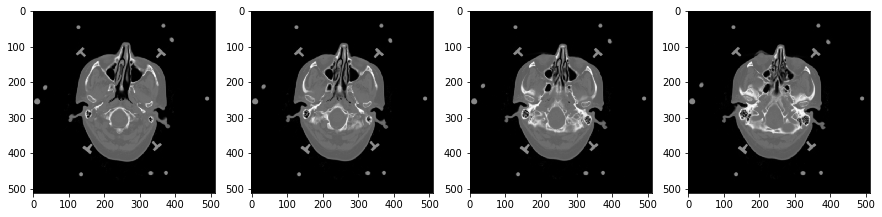

<Figure size 432x288 with 0 Axes>

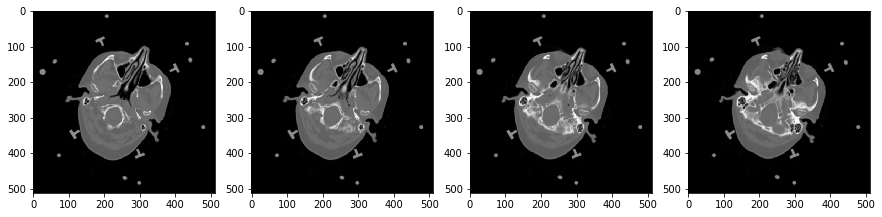

<Figure size 432x288 with 0 Axes>

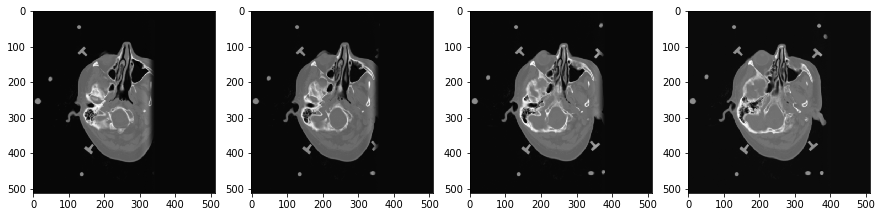

In [118]:
offset = 5
plot_slices(scan, offset=offset)
plot_slices(s_rot, offset=offset)
plot_slices(s_rot2, offset=offset)

In [120]:
np.max(s_rot2)

3372.264773808709